In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shrutimechlearn/churn-modelling")

print("Path to dataset files:", path)

100%|████████████████████████████████████████████████████████████████████████████████| 262k/262k [00:00<00:00, 691kB/s]

Extracting files...
Path to dataset files: C:\Users\Jorge\.cache\kagglehub\datasets\shrutimechlearn\churn-modelling\versions\1


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [42]:
dataset_path=fr"C:\Users\Jorge\.cache\kagglehub\datasets\shrutimechlearn\churn-modelling\versions\1"

file_path = os.path.join(dataset_path1, "Churn_Modelling.csv") 
df = pd.read_csv(file_path)

# Mostrar las primeras filas
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data cleaning

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [44]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [45]:
df[df.duplicated()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


## Data Exploration

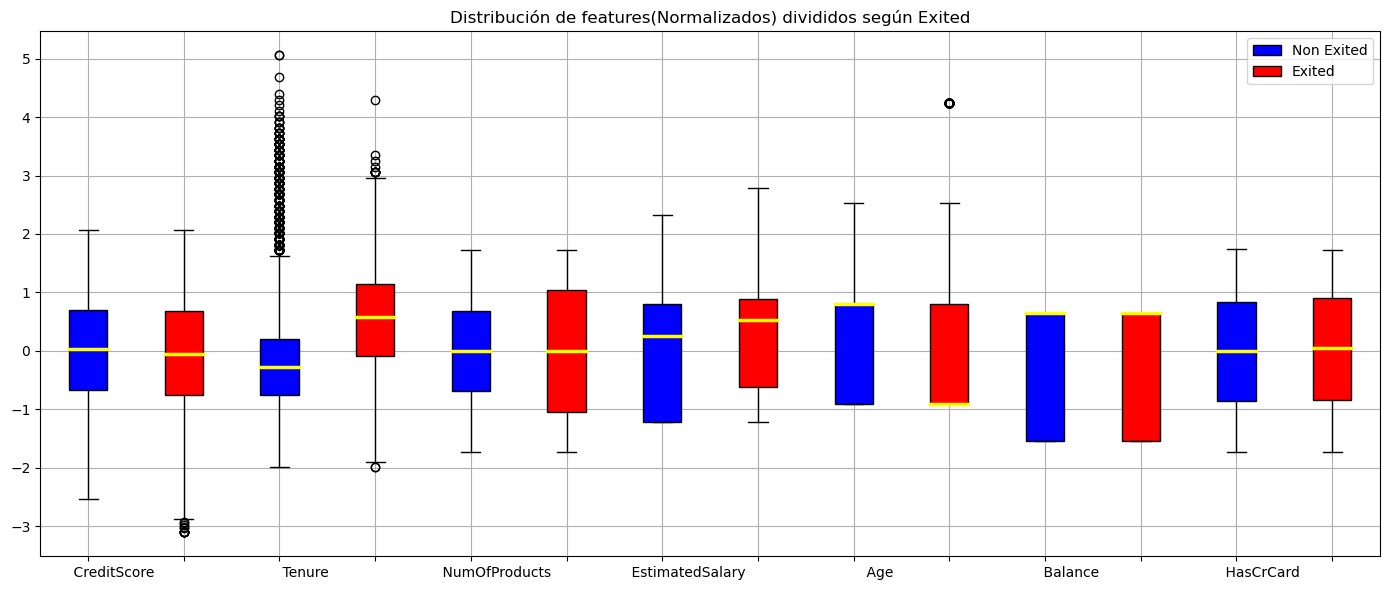

In [68]:
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary']

# Eliminar outliers usando los percentiles 1% y 99%
df_filtered = df.copy()
for feature in numerical_features:
    lower_bound = df[feature].quantile(0)
    upper_bound = df[feature].quantile(1)
    df_filtered = df_filtered[(df_filtered[feature] >= lower_bound) & (df_filtered[feature] <= upper_bound)]

# Normalizar las features usando Z-score (Estandarización)
df_normalized = df_filtered.copy()
for feature in numerical_features:
    mean_val = df_filtered[feature].mean()
    std_val = df_filtered[feature].std()
    df_normalized[feature] = (df_filtered[feature] - mean_val) / std_val


# Separar los datos por el valor de 'Exited'
df_exited_0 = df_normalized[df_filtered['Exited'] == 0]
df_exited_1 = df_normalized[df_filtered['Exited'] == 1]

# Crear un solo gráfico con boxplots lado a lado por feature y Exited
fig, ax = plt.subplots(figsize=(14, 6))

box_data = []
box_labels = []
box_colors = []

for feature in numerical_features:
    box_data.append(df_exited_0[feature])
    box_labels.append(feature)
    box_colors.append('blue')
    
    box_data.append(df_exited_1[feature])
    box_labels.append(feature)
    box_colors.append('red')

# Crear boxplot
boxplot = ax.boxplot(box_data, patch_artist=True, widths=0.4)
for median in boxplot['medians']:
    median.set(color='yellow', linewidth=2.5)

# Aplicar colores
for patch, color in zip(boxplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Personalizar el gráfico
ax.set_title("Distribución de features(Normalizados) divididos según Exited")

xtickslabels = ["            "+feature if i % 2 == 0 else "" for i, feature in enumerate(numerical_features * 2)]

ax.set_xticklabels(xtickslabels, rotation=0)
ax.legend([boxplot["boxes"][0], boxplot["boxes"][1]], ["Non Exited", "Exited"], loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
print(df_filtered[df_filtered['Exited'] == 0]['Age'].describe())
print(df_filtered[df_filtered['Exited'] == 1]['Age'].describe())


count    5034.000000
mean       36.886770
std         7.161383
min        25.000000
25%        32.000000
50%        36.000000
75%        41.000000
max        60.000000
Name: Age, dtype: float64
count    1100.000000
mean       44.200909
std         8.222044
min        25.000000
25%        38.000000
50%        45.000000
75%        50.000000
max        60.000000
Name: Age, dtype: float64


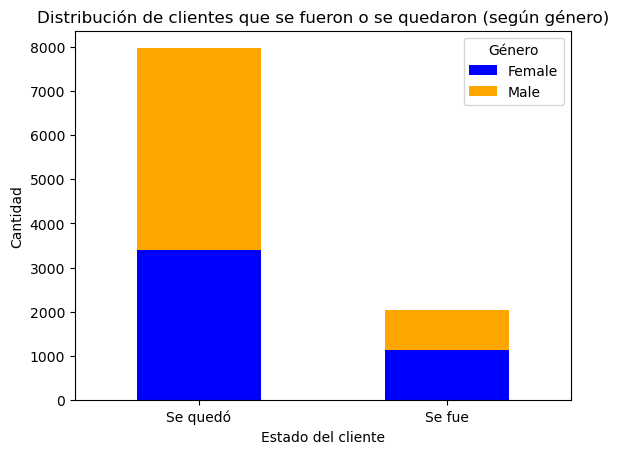

In [46]:
# Contar la cantidad de clientes que se quedaron o se fueron, separados por género
churn_gender_counts = df.groupby(["Exited", "Gender"]).size().unstack()

# Graficar barras apiladas
churn_gender_counts.plot(kind="bar", stacked=True, color=["blue", "orange"])

# Personalizar el gráfico
plt.title("Distribución de clientes que se fueron o se quedaron (según género)")
plt.xlabel("Estado del cliente")
plt.ylabel("Cantidad")
plt.xticks(ticks=[0, 1], labels=["Se quedó", "Se fue"], rotation=0)
plt.legend(title="Género")
plt.show()

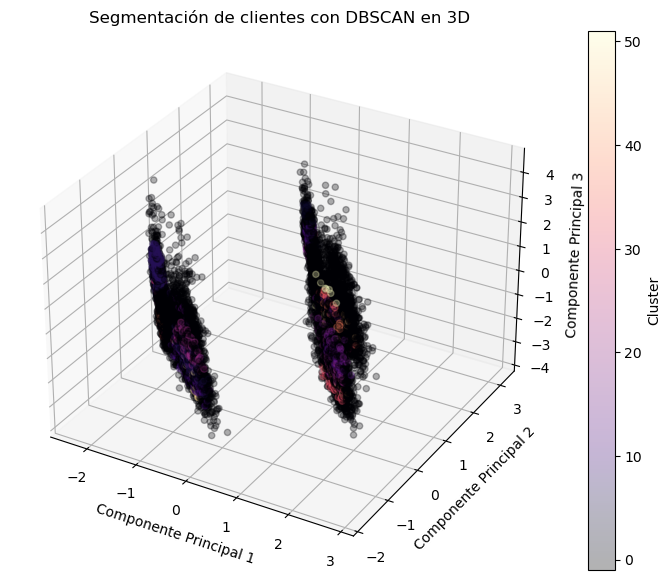

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Suponiendo que ya tienes cargado tu dataframe df con las siguientes columnas:
features = [
    'CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
    'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 
    'Geography_Germany', 'Geography_Spain', 'Geography_France'
]

# Extraer los datos de las columnas de interés
data = df[features]

# Escalar los datos para que cada variable contribuya de manera similar
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Aplicar DBSCAN
# Nota: eps y min_samples son hiperparámetros que puedes ajustar según tu dataset
dbscan = DBSCAN(eps=1, min_samples=10)
clusters = dbscan.fit_predict(data_scaled)

# Añadir la etiqueta de cluster al dataframe
df['cluster'] = clusters

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necesario para gráficos 3D

# Reducir la dimensionalidad a 3 componentes para visualizar en 3D
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_scaled)

# Crear la figura y el subplot 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Graficar los clusters en 3D
scatter = ax.scatter(
    data_pca[:, 0], data_pca[:, 1], data_pca[:, 2],
    c=clusters, cmap='magma', alpha=0.3
)

# Etiquetas y título
ax.set_title("Segmentación de clientes con DBSCAN en 3D")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")

# Añadir la barra de color
plt.colorbar(scatter, ax=ax, label='Cluster')

plt.show()

El cluster más representado es: -1


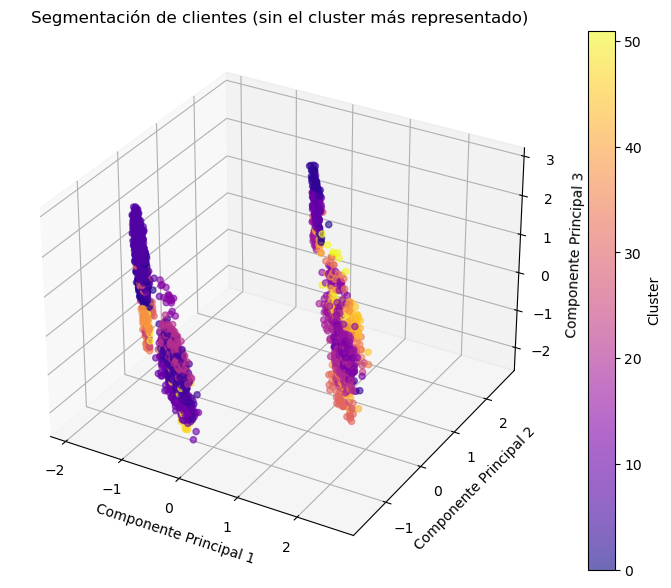

In [122]:
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_scaled)

# Determinar el cluster más representado (excluyendo el ruido, es decir, -1)
unique_labels, counts = np.unique(clusters, return_counts=True)
# Filtrar para excluir el ruido (-1) en el cálculo, si se desea
mask = unique_labels #!= -1
if np.any(mask):
    labels_sin_ruido = unique_labels[mask]
    counts_sin_ruido = counts[mask]
    most_represented_cluster = labels_sin_ruido[np.argmax(counts_sin_ruido)]
else:
    most_represented_cluster = -1

print("El cluster más representado es:", most_represented_cluster)

# Filtrar los datos para excluir el cluster más representado
filter_mask = clusters != most_represented_cluster
data_pca_filtered = data_pca[filter_mask]
clusters_filtered = clusters[filter_mask]

# Crear la figura y el subplot 3D para graficar los datos filtrados
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos filtrados utilizando un colormap (por ejemplo, "plasma")
scatter = ax.scatter(
    data_pca_filtered[:, 0],
    data_pca_filtered[:, 1],
    data_pca_filtered[:, 2],
    c=clusters_filtered, cmap='plasma', alpha=0.6
)

# Etiquetas y título
ax.set_title("Segmentación de clientes (sin el cluster más representado)")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")

# Añadir la barra de color
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.show()

## Training

In [69]:
label_encoder=LabelEncoder()
df['Gender']=label_encoder.fit_transform(df['Gender'])
df=pd.get_dummies(df, columns=['Geography'])

In [70]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,0,42,2,0.00,1,1,1,101348.88,1,True,False,False
1,2,15647311,Hill,608,0,41,1,83807.86,1,0,1,112542.58,0,False,False,True
2,3,15619304,Onio,502,0,42,8,159660.80,3,1,0,113931.57,1,True,False,False
3,4,15701354,Boni,699,0,39,1,0.00,2,0,0,93826.63,0,True,False,False
4,5,15737888,Mitchell,850,0,43,2,125510.82,1,1,1,79084.10,0,False,False,True


In [71]:
features = [
    'CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
    'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 
    'Geography_Germany', 'Geography_Spain', 'Geography_France'
]


X= df[features]
y=df['Exited']

In [87]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar y transformar manteniendo los nombres de las columnas
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [88]:
model= RandomForestClassifier(n_estimators=100, random_state=42)

In [89]:
model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [90]:
y_pred=model.predict(X_test)

In [91]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)


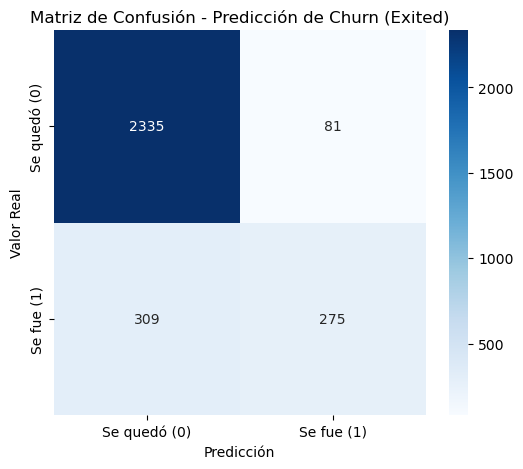

In [93]:
# Visualizar con heatmap de Seaborn con nombres adecuados
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Se quedó (0)", "Se fue (1)"], 
            yticklabels=["Se quedó (0)", "Se fue (1)"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - Predicción de Churn (Exited)")
plt.show()

In [97]:
print(class_report)
print('accuracy', accuracy)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.77      0.47      0.59       584

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.75      3000
weighted avg       0.86      0.87      0.86      3000

accuracy 0.87


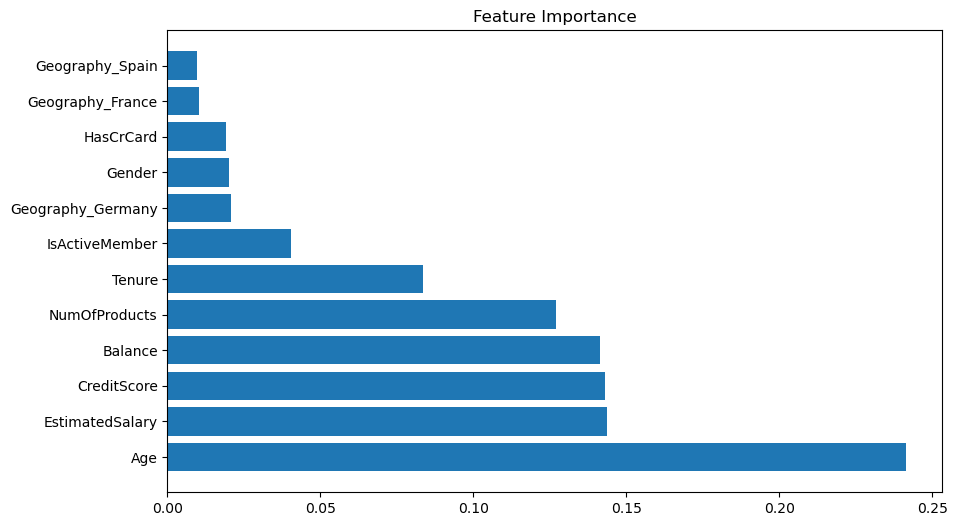

In [98]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [features[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(X.shape[1]), importances[indices])
plt.yticks(range(X.shape[1]), names)
plt.show()

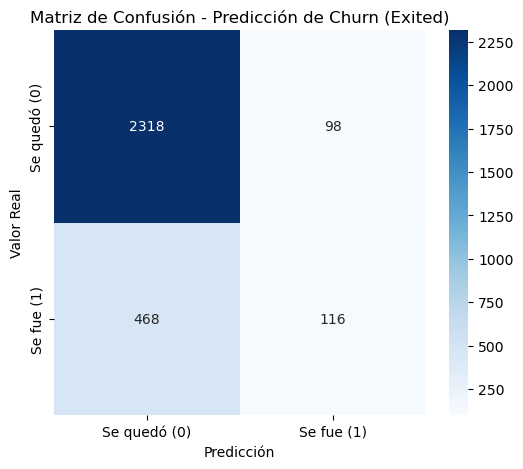

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2416
           1       0.54      0.20      0.29       584

    accuracy                           0.81      3000
   macro avg       0.69      0.58      0.59      3000
weighted avg       0.78      0.81      0.77      3000
 0.8113333333333334


In [100]:
from sklearn.linear_model import LogisticRegression

# Build and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the model
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
class_report_log_reg = classification_report(y_test, y_pred_log_reg)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)


# Visualizar con heatmap de Seaborn con nombres adecuados
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Se quedó (0)", "Se fue (1)"], 
            yticklabels=["Se quedó (0)", "Se fue (1)"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - Predicción de Churn (Exited)")
plt.show()
print(class_report_log_reg, accuracy_log_reg)


C:\Users\Jorge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jorge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jorge\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


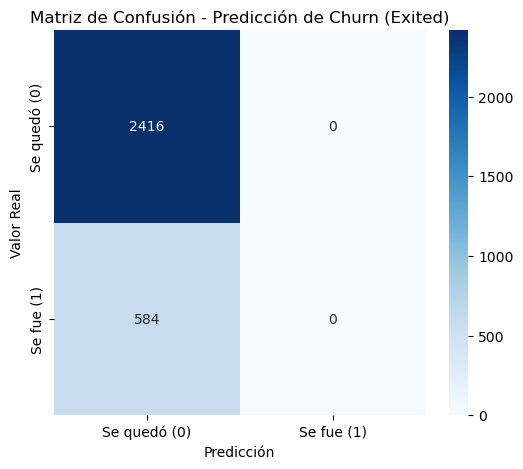

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      2416
           1       0.00      0.00      0.00       584

    accuracy                           0.81      3000
   macro avg       0.40      0.50      0.45      3000
weighted avg       0.65      0.81      0.72      3000
 0.8053333333333333


In [101]:
from sklearn.svm import SVC

# Build and train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
class_report_svm = classification_report(y_test, y_pred_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)


# Visualizar con heatmap de Seaborn con nombres adecuados
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Se quedó (0)", "Se fue (1)"], 
            yticklabels=["Se quedó (0)", "Se fue (1)"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión - Predicción de Churn (Exited)")
plt.show()
print( class_report_svm, accuracy_svm)


In [102]:
from sklearn.neighbors import KNeighborsClassifier

# Build and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
class_report_knn = classification_report(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(conf_matrix_knn, class_report_knn, accuracy_knn)


[[2291  125]
 [ 375  209]]               precision    recall  f1-score   support

           0       0.86      0.95      0.90      2416
           1       0.63      0.36      0.46       584

    accuracy                           0.83      3000
   macro avg       0.74      0.65      0.68      3000
weighted avg       0.81      0.83      0.81      3000
 0.8333333333333334
